# DFT mit Fensterung #
## Rechteckfensterung
In diesem Notebook beschäftigen wir uns mit der spektralen Darstellung von Zeitsignalen. Für die praktische (= computerbasierte, nicht analytische) Signalverarbeitung kann man nur endliche Anzahl Samples von unendlich ausgedehnten Signalen verarbeiten. Das Herausschneiden dieser Samples nennt man *Fensterung*. Wir werden sehen, dass die Art der Fensterung (Anzahl der Samples, Fensterungsfunktion) einen großen Einfluss auf die Frequenz- und Amplitudenauflösung hat.


In [15]:
import os, sys
my_path = os.path.abspath(os.path.join('../')) # append directory one level up to import path
if my_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(my_path)
import dsp_fpga_lib as dsp # import and set plot properties
    
import matplotlib.pyplot as plt
# nächste Zeile auskommentieren für interaktive Fenster
%matplotlib inline
import numpy as np
from numpy import linspace, log10, cos, sin, pi
from numpy.fft import fft, fftshift, fftfreq

import scipy.signal as sig

plt.rcParams["figure.figsize"] = [9, 5]

Zunächst werden Abtastfrequenz und die Zahl der FFT-Punkte festgelegt. Daraus ergibt sich automatisch die Länge des Messfensters $T_{mess} = T_S N_{FFT}$ und die Frequenzauflösung $\Delta f = f_S / N_{FFT} = 1 / T_{mess}$:

In [16]:
f_S = 1e4 # sample frequency 
T_S = 1./f_S 
N_FFT = 500 
T_mess = T_S * N_FFT
Delta_f = f_S / N_FFT

print ('T_mess =', T_mess, 's')
print ('Delta f =', Delta_f, 'Hz')

T_mess = 0.05 s
Delta f = 20.0 Hz


Um die Frequenz- und Amplitudenauflösung verschiedener Szenarien zu vergleichen, erzeugen wir uns ein Testsignal mit zwei Tönen unterschiedlicher Frequenz $f_a, f_b$ und Amplitude $A_a, A_b$ und überlagertem weißem gaußschem Rauschen (AWGN) mit der Standardabweichung $\sigma$:

f_a =  1000.0 Hz 
f_b =  1050.0 Hz


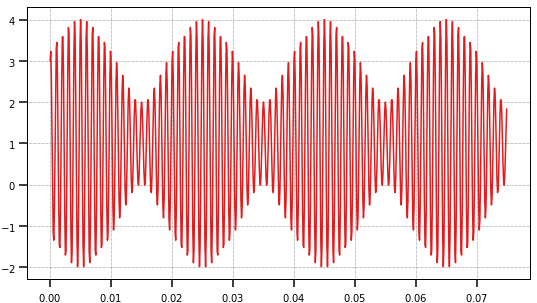

In [17]:
A_a = 2; f_a = Delta_f * 50 # Ton a, genau auf Auswertefrequenz
A_b = 1; f_b = Delta_f * 52.5  # Ton b, auch genau auf Auswertefrequenz
DC = 1.
sigma = 0.0 # standard deviation of AWGN
fmin = 900  # untere Frequenz und
fmax = 1100 # obere Frequenz für Spektrumsplots
t = linspace(0, T_mess * 1.5, int(N_FFT * 1.5), endpoint = False) # Start / Stop / Anzahl
y = DC + A_a * cos(2 * pi * t * f_a) + A_b * sin(2 * pi * t * f_b) + sigma * np.random.randn(len(t)) # y[n]
print ('f_a = ', f_a, 'Hz \nf_b = ', f_b, 'Hz')
plt.plot(t,y);

Zur Spektralanalyse wird die DFT der Zeitfunktion berechnet. In Python (und den meisten anderen Programmiersprachen für Scientific Computing) wird die DFT über den kompletten Bereich $0 \ldots f_S$ berechnet. Bei reellwertigen Zeitsignalen sind aber die Teilspektren zwischen $0 \ldots f_S /2 $ und zwischen $f_S/2 \ldots f_S$ symmetrisch zueinander, man beschränkt sich daher in der Darstellung meist auf den Bereich $0 \ldots f_S /2 $. Damit trotzdem die Gesamtleistung auch im Frequenzbereich korrekt dargestellt wird (Parcevalsche Beziehung), wird das Spektrum (außer bei $f = 0$) mit dem Faktor 2 skaliert. 

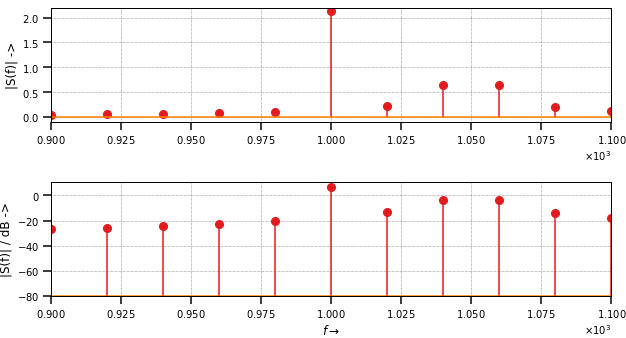

In [18]:
# DFT bei f = [0 ... f_S[ = [0... f_S/2[, [-f_S/2 ... 0[ :
Sy = 2 * fft(y[0:N_FFT], N_FFT) / N_FFT # skaliere für einseitiges Spektrum
Sy[0] = Sy[0] / 2 # korrigiere DC-Wert
f = fftfreq(N_FFT, T_S) 
# freq. points at [0... f_S/2[, [-f_S/2 ..
fig2 = plt.figure(2)
ax21 = fig2.add_subplot(211)
ax21.stem(f, abs(Sy)) 
ax21.set_xlim(fmin, fmax); ax21.set_ylim(-0.1, max(A_a, A_b)*1.1)
ax21.set_ylabel('|S(f)| ->')
ax22 = fig2.add_subplot(212)
ax22.stem(f, 20*log10(abs(Sy)), bottom = -80) 
ax22.set_xlim(fmin, fmax); ax22.set_ylim(-80, max(20*log10(A_a), 20*log10(A_b))+5)
ax22.set_xlabel(r'$f \rightarrow$'); ax22.set_ylabel('|S(f)| / dB ->')
fig2.tight_layout()

Wir berechnen die DFT aus $N_{FFT}$ Datenpunkten und erhalten $N_{FFT}$ Frequenzpunkte. *Wenn* wir uns ein zeitdiskretes, unendlich ausgedehntes Signal $y[n]$ vorstellen, bei dem sich diese $N_{FFT}$ Datenpunkte periodisch wiederholen, liefert die **DTFT** exakt das gleiche Ergebnis wie die **DFT**. Wenn wir uns jetzt noch vorstellen, dass $y[n]$ aus einem zeitkontinuierlichen  Tiefpasssignal $y(t)$ durch Abtastung ohne Aliasing gewonnen wurde, liefert die DFT an den $N_{FFT}$ Frequenzpunkten exakt das gleichen Spektralwerte wie die **CFT**. Das können Sie in der Simulation ausprobieren, indem Sie Signalfrequenzen wählen, die exakt auf die Auswertefrequenzen der DFT fallen. Liegen die Signalfrequenzenen dazwischen, bekommen Sie Frequenz- und Amplitudenfehler.

In [19]:
## Fensterfunktionen

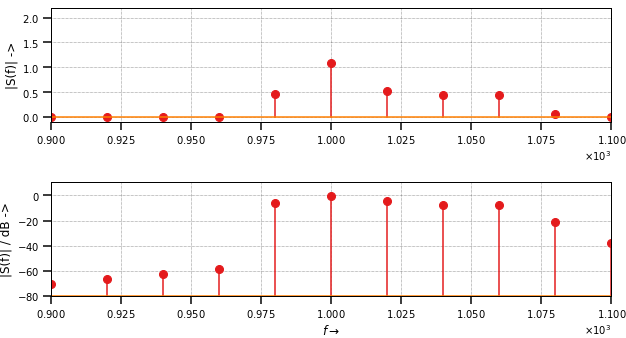

In [20]:
fig3 = plt.figure(3)
ax31 = fig3.add_subplot(211)
w = sig.windows.hamming(N_FFT)
Sy = 2 * fft(y[0:N_FFT]*w, N_FFT) / N_FFT
ax31.stem(f, abs(Sy)) 
ax31.set_xlim(fmin, fmax); ax31.set_ylim(-0.1, max(A_a, A_b)*1.1)
ax31.set_ylabel('|S(f)| ->')
ax32 = fig3.add_subplot(212)

w = sig.windows.hann(N_FFT)
Sy = 2 * fft(y[0:N_FFT]*w, N_FFT) / N_FFT
ax32.stem(f, 20*log10(abs(Sy)), bottom = -80) 
ax32.set_xlim(fmin, fmax); ax32.set_ylim(-80, max(20*log10(A_a), 20*log10(A_b))+5)
ax32.set_xlabel(r'$f \rightarrow$'); ax32.set_ylabel('|S(f)| / dB ->')
fig3.tight_layout()
